In [2340]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
#t_visible(False)
plt.show()
from lmfit import minimize, Parameters, Parameter, report_fit

In [2341]:
np.set_printoptions(suppress=True)

In [2342]:
data=pd.read_csv('covid_data_peru.csv', encoding = "ISO-8859-1")

In [2343]:
data.head()

,fecha,casos_totales,casos_activos,recuperados
0,06/03/20,1,1,0
1,07/03/20,6,6,0
2,08/03/20,7,7,0
3,09/03/20,9,9,0
4,10/03/20,11,11,0


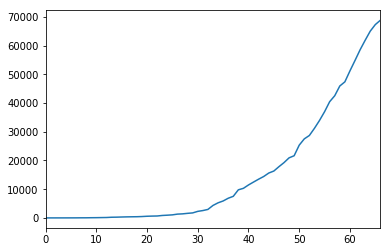

In [2344]:
data.casos_totales.plot()

Text(0.5, 1.0, 'Nuevos Casos - Media Móvil 5 días')

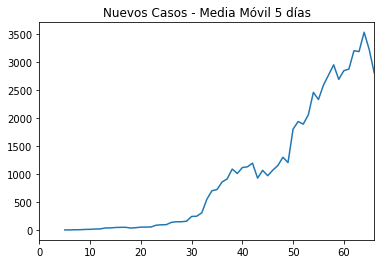

In [2454]:
data.casos_totales.diff().rolling(5).mean().plot()
plt.title('Nuevos Casos - Media Móvil 5 días')

In [2345]:
cases=pd.to_numeric(data['casos_totales'], downcast="float")
recuperados=pd.to_numeric(data['recuperados'], downcast="float")

In [2346]:
# Total population, N.
#N = 8575000
N = 80000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.01, 0.01
# A grid of time points (in days)
t = np.linspace(0, len(cases)-1, len(cases))

In [2438]:
print('Dia del contagio: ',len(t))

Dia del contagio:  67


In [2348]:
# set parameters including bounds; you can also fix parameters (use vary=False)
params = Parameters()
params.add('S0', value=S0, vary=False)
params.add('I0', value=I0, vary=False)
params.add('R0', value=R0, vary=False)
params.add('beta', value=beta, min=0.0001, max=7.)
params.add('gamma', value=gamma, min=0.002, max=3.)
#params.add('gamma', value=gamma,min=0.00020,max=0.00040,vary=True)
#params.add('gamma', value=gamma,vary=False)
params.add('N', value=N, vary = False)

In [2349]:
# The SIR model differential equations.4
def deriv(y, t, paras):
    
    try:
        beta = paras['beta'].value
        gamma = paras['gamma'].value
        N = paras['N'].value
        
    except KeyError:
        beta, gamma,N = paras
    
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [2350]:
# Initial conditions vector
y0 = [S0, I0, R0]
# Integrate the SIR equations over the time grid, t.
#ret = odeint(deriv, y0, t, args=(paras,))
#S, I, R = ret.T
#paras= (N, beta, gamma)

In [2351]:
#x0 es y0

def g(t, x0, paras):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """ 
    x = odeint(deriv, x0, t, args=(paras,) )
    return x


In [2352]:
def residual(paras, t, data):

    """
    compute the residual between actual data and fitted data
    """

    x0 = paras['S0'].value, paras['I0'].value, paras['R0'].value # Initial Conditions
    model = g(t, x0, paras)

    # you only have data for one of your variables
    x2_model = model.T[1]
    x3_model = model.T[2]
    # 50% , 50%
    return ((x2_model - cases)*0.50+(x3_model-recuperados)*0.50).ravel()

In [2353]:
result = minimize(residual, params, args=(t, cases), method='leastsq',nan_policy='omit')  # leastsq nelder

In [2354]:
result.params

name,value,standard error,relative error,initial value,min,max,vary
S0,79999.0000,0.00000000,(0.00%),79999,-inf,inf,False
I0,1.00000000,0.00000000,(0.00%),1,-inf,inf,False
R0,0.00000000,0.00000000,,0,-inf,inf,False
beta,0.22805527,0.02592229,(11.37%),0.01,1.0000e-04,7.00000000,True
gamma,0.00731766,0.02644503,(361.39%),0.01,0.00200000,3.00000000,True
N,80000.0000,0.00000000,(0.00%),80000,-inf,inf,False


In [2355]:
time =np.linspace(0., 400, 401)

In [2356]:
data_fitted = g(time, y0, result.params)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 120
    # data points      = 67
    # variables        = 2
    chi-square         = 4.9279e+08
    reduced chi-square = 7581440.44
    Akaike info crit   = 1063.33086
    Bayesian info crit = 1067.74025
[[Variables]]
    S0:     79999 (fixed)
    I0:     1 (fixed)
    R0:     0 (fixed)
    beta:   0.22805527 +/- 0.02592229 (11.37%) (init = 0.01)
    gamma:  0.00731766 +/- 0.02644503 (361.39%) (init = 0.01)
    N:      80000 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma) =  0.998


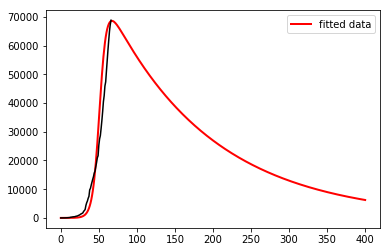

In [2357]:
plt.plot(time, data_fitted[:, 1], '-', linewidth=2, color='red', label='fitted data')
#plt.plot(time, data_fitted[:, 2], '-', linewidth=2, color='green', label='recover')
#plt.plot(time, data_fitted[:, 0], '-', linewidth=2, color='blue', label='Susceptible')
plt.legend()
plt.plot(cases,color='black',label='Data')
report_fit(result)

plt.show()

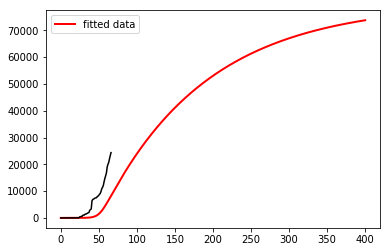

In [2358]:
plt.plot(time, data_fitted[:, 2], '-', linewidth=2, color='red', label='fitted data')
#plt.plot(time, data_fitted[:, 2], '-', linewidth=2, color='green', label='recover')
#plt.plot(time, data_fitted[:, 0], '-', linewidth=2, color='blue', label='Susceptible')
plt.legend()
plt.plot(recuperados,color='black',label='Data')
plt.show()

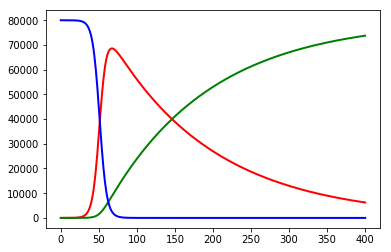

In [2359]:
plt.plot(time, data_fitted[:, 1], '-', linewidth=2, color='red', label='fitted data')
plt.plot(time, data_fitted[:, 2], '-', linewidth=2, color='green', label='recover')
plt.plot(time, data_fitted[:, 0], '-', linewidth=2, color='blue', label='Susceptible')

# Modelo incluyendo no expuestos

In [2360]:
# Total population, N.
#N = 21000000
N = 80000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 ,e= 1, 0,0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.01, 0.01
# A grid of time points (in days)
t = np.linspace(0, len(cases)-1, len(cases))

In [2361]:
len(t)

67

In [2362]:
# set parameters including bounds; you can also fix parameters (use vary=False)
params = Parameters()
params.add('S0', value=S0, vary=False)
params.add('I0', value=I0, vary=False)
params.add('R0', value=R0, vary=False)
params.add('beta', value=beta, min=0.0001, max=7.)
params.add('gamma', value=gamma, min=0.002, max=3.)
params.add('e', value=0.000001 , min=0.000001, max=1.)
#params.add('gamma', value=gamma,min=0.00020,max=0.00040,vary=True)
#params.add('gamma', value=gamma,vary=False)
params.add('N', value=N, vary = False)

In [2363]:
# The SIR model differential equations.4
def deriv(y, t, paras):
    
    try:
        beta = paras['beta'].value
        gamma = paras['gamma'].value
        e = paras['e'].value
        N = paras['N'].value
        
    except KeyError:
        beta, gamma,N = paras
    
    S, I, R = y
    dSdt = -beta * S * I /N -S * e /N
    dIdt = beta * S * I /N  - gamma * I
    dRdt = gamma * I + S * e /N
    #dEdt = S*e/N
    return dSdt, dIdt, dRdt #,dEdt

In [2364]:
# Initial conditions vector
y0 = [S0, I0, R0]
# Integrate the SIR equations over the time grid, t.
#ret = odeint(deriv, y0, t, args=(paras,))
#S, I, R = ret.T
#paras= (N, beta, gamma)

In [2365]:
#x0 es y0

def g(t, x0, paras):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """ 
    x = odeint(deriv, x0, t, args=(paras,) )
    return x


In [2366]:
def residual(paras, t, data):

    """
    compute the residual between actual data and fitted data
    """

    x0 = paras['S0'].value, paras['I0'].value, paras['R0'].value#,paras['e'].value # Initial Conditions
    model = g(t, x0, paras)

    # you only have data for one of your variables
    x2_model = model.T[1]
    x3_model = model.T[2]
    # 50% , 50%
    #return ((x2_model - cases)*0.50+(x3_model-recuperados)*0.50).ravel()
    return np.concatenate(((x2_model - cases),(x3_model-recuperados)))

In [2367]:
result = minimize(residual, params, args=(t, cases), method='leastsq',nan_policy='omit')  # leastsq nelder

In [2368]:
result.params

name,value,standard error,relative error,initial value,min,max,vary
S0,79999.0000,0.00000000,(0.00%),79999,-inf,inf,False
I0,1.00000000,0.00000000,(0.00%),1,-inf,inf,False
R0,0.00000000,0.00000000,,0,-inf,inf,False
beta,0.23936951,0.00188562,(0.79%),0.01,1.0000e-04,7.00000000,True
gamma,0.02384095,0.00192892,(8.09%),0.01,0.00200000,3.00000000,True
e,0.99999996,11.9793062,(1197.93%),1e-06,1.0000e-06,1.00000000,True
N,80000.0000,0.00000000,(0.00%),80000,-inf,inf,False


In [2369]:
time =np.linspace(0., 400, 401)

In [2370]:
data_fitted = g(time, y0, result.params)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1676
    # data points      = 134
    # variables        = 3
    chi-square         = 1.7914e+09
    reduced chi-square = 13674464.0
    Akaike info crit   = 2204.72536
    Bayesian info crit = 2213.41888
[[Variables]]
    S0:     79999 (fixed)
    I0:     1 (fixed)
    R0:     0 (fixed)
    beta:   0.23936951 +/- 0.00188562 (0.79%) (init = 0.01)
    gamma:  0.02384095 +/- 0.00192892 (8.09%) (init = 0.01)
    e:      0.99999996 +/- 11.9793062 (1197.93%) (init = 1e-06)
    N:      80000 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, e)    =  0.733
    C(beta, gamma) =  0.602
    C(beta, e)     =  0.145


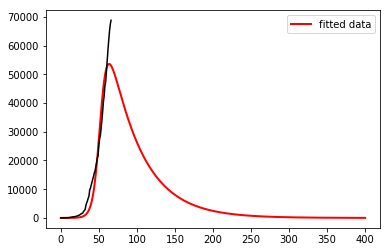

In [2371]:
plt.plot(time, data_fitted[:, 1], '-', linewidth=2, color='red', label='fitted data')
#plt.plot(time, data_fitted[:, 2], '-', linewidth=2, color='green', label='recover')
#plt.plot(time, data_fitted[:, 0], '-', linewidth=2, color='blue', label='Susceptible')
plt.legend()
plt.plot(cases,color='black',label='Data')
report_fit(result)

plt.show()

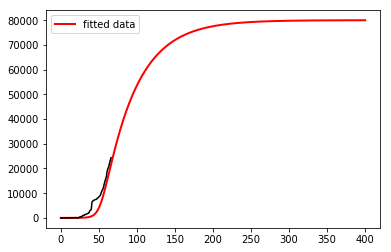

In [2372]:
plt.plot(time, data_fitted[:, 2], '-', linewidth=2, color='red', label='fitted data')
#plt.plot(time, data_fitted[:, 2], '-', linewidth=2, color='green', label='recover')
#plt.plot(time, data_fitted[:, 0], '-', linewidth=2, color='blue', label='Susceptible')
plt.legend()
plt.plot(recuperados,color='black',label='Data')
plt.show()

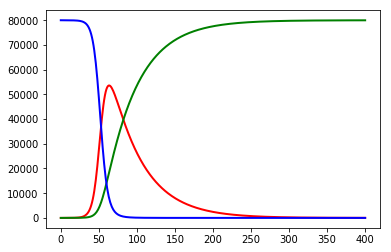

In [2373]:
plt.plot(time, data_fitted[:, 1], '-', linewidth=2, color='red', label='fitted data')
plt.plot(time, data_fitted[:, 2], '-', linewidth=2, color='green', label='recover')
plt.plot(time, data_fitted[:, 0], '-', linewidth=2, color='blue', label='Susceptible')

# Modelo de fracción de sensibles

In [2374]:
# Total population, N.
#N = 31000000
N = 150000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma,e = 0.01, 0.01,0.000001
# A grid of time points (in days)
t = np.linspace(0, len(cases)-1, len(cases))

In [2375]:
len(t)

67

In [2376]:
# set parameters including bounds; you can also fix parameters (use vary=False)
params = Parameters()
params.add('S0', value=S0, vary=False)
params.add('I0', value=I0, vary=False)
params.add('R0', value=R0, vary=False)
params.add('beta', value=beta, min=0.0001, max=7.)
params.add('gamma', value=gamma, min=0.002, max=3.)
params.add('e', value=e , min=0.000001, max=3.)
#params.add('gamma', value=gamma,min=0.00020,max=0.00040,vary=True)
#params.add('gamma', value=gamma,vary=False)
#params.add('N', value=N, vary = True, min=60000,max= 300000)
params.add('N', value=N, vary = False)

In [2377]:
# The SIR model differential equations.4
def deriv(y, t, paras):
    
    try:
        beta = paras['beta'].value
        gamma = paras['gamma'].value
        e = paras['e'].value
        N = paras['N'].value
        
    except KeyError:
        beta, gamma,N = paras
        
    
    S, I, R = y
    #dSdt = -beta * S * I /(N*e)
    #dIdt = beta * S * I /(N*e)  - gamma * I
    #Mejor
    dSdt = -beta * S * I /(N)
    dIdt = beta * S * I /(N)  - gamma * I
    #Cambio
    #dSdt = -beta * S * I 
    #dIdt = beta * S * I   - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [2378]:
# Initial conditions vector
y0 = [S0, I0, R0]
# Integrate the SIR equations over the time grid, t.
#ret = odeint(deriv, y0, t, args=(paras,))
#S, I, R = ret.T
#paras= (N, beta, gamma)

In [2379]:
#x0 es y0

def g(t, x0, paras):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """ 
    x = odeint(deriv, x0, t, args=(paras,) )
    return x


In [2380]:
def residual(paras, t, data):

    """
    compute the residual between actual data and fitted data
    """

    x0 = paras['S0'].value, paras['I0'].value, paras['R0'].value # Initial Conditions
    model = g(t, x0, paras)

    # you only have data for one of your variables
    x2_model = model.T[1]
    x3_model = model.T[2]
    # 50% , 50%
    return np.concatenate(((x2_model - cases),(x3_model-recuperados)))

In [2381]:
result = minimize(residual, params, args=(t, cases), method='leastsq',nan_policy='omit')  # leastsq nelder

In [2382]:
result.params

name,value,initial value,min,max,vary
S0,149999.000,149999,-inf,inf,False
I0,1.00000000,1,-inf,inf,False
R0,0.00000000,0,-inf,inf,False
beta,0.23972101,0.01,1.0000e-04,7.00000000,True
gamma,0.04310813,0.01,0.00200000,3.00000000,True
e,1.0000e-06,1e-06,1.0000e-06,3.00000000,True
N,150000.000,150000,-inf,inf,False


In [2383]:
time =np.linspace(0., 400, 401)

In [2384]:
data_fitted = g(time, y0, result.params)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 126
    # data points      = 134
    # variables        = 3
    chi-square         = 2.4701e+09
    reduced chi-square = 18855804.5
    Akaike info crit   = 2247.77831
    Bayesian info crit = 2256.47183
##  Warning: uncertainties could not be estimated:
    e:      at initial value
    e:      at boundary
[[Variables]]
    S0:     149999 (fixed)
    I0:     1 (fixed)
    R0:     0 (fixed)
    beta:   0.23972101 (init = 0.01)
    gamma:  0.04310813 (init = 0.01)
    e:      1.0000e-06 (init = 1e-06)
    N:      150000 (fixed)


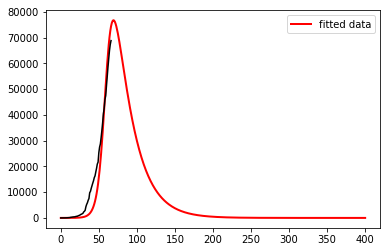

In [2385]:
plt.plot(time, data_fitted[:, 1], '-', linewidth=2, color='red', label='fitted data')
#plt.plot(time, data_fitted[:, 2], '-', linewidth=2, color='green', label='recover')
#plt.plot(time, data_fitted[:, 0], '-', linewidth=2, color='blue', label='Susceptible')
plt.legend()
plt.plot(cases,color='black',label='Data')
report_fit(result)

plt.show()

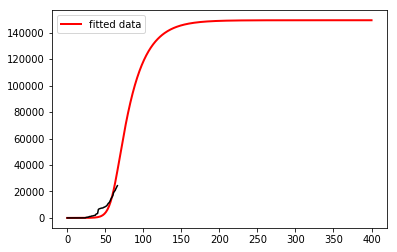

In [2386]:
plt.plot(time, data_fitted[:, 2], '-', linewidth=2, color='red', label='fitted data')
#plt.plot(time, data_fitted[:, 2], '-', linewidth=2, color='green', label='recover')
#plt.plot(time, data_fitted[:, 0], '-', linewidth=2, color='blue', label='Susceptible')
plt.legend()
plt.plot(recuperados,color='black',label='Data')
plt.show()

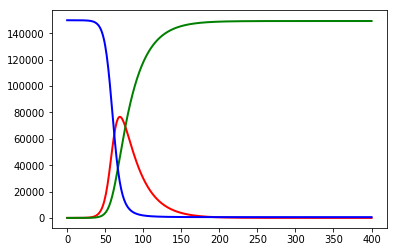

In [2387]:
plt.plot(time, data_fitted[:, 1], '-', linewidth=2, color='red', label='fitted data')
plt.plot(time, data_fitted[:, 2], '-', linewidth=2, color='green', label='recover')
plt.plot(time, data_fitted[:, 0], '-', linewidth=2, color='blue', label='Susceptible')

# Modelo de suceptibles variantes

In [2388]:
# Total population, N.
#N = 31000000
N = 150000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma,e = 0.01, 0.01,0.000001
# A grid of time points (in days)
t = np.linspace(0, len(cases)-1, len(cases))

In [2389]:
len(t)

67

In [2390]:
# set parameters including bounds; you can also fix parameters (use vary=False)
params = Parameters()
params.add('S0', value=S0, vary=False)
params.add('I0', value=I0, vary=False)
params.add('R0', value=R0, vary=False)
params.add('beta', value=beta, min=0.0001, max=7.)
params.add('gamma', value=gamma, min=0.002, max=3.)
params.add('e', value=e , min=0.000001, max=3.)
#params.add('gamma', value=gamma,min=0.00020,max=0.00040,vary=True)
#params.add('gamma', value=gamma,vary=False)
#params.add('N', value=N, vary = True, min=60000,max= 300000)
params.add('N', value=N, vary = False)

In [2391]:
# The SIR model differential equations.4
def deriv(y, t, paras):
    
    try:
        beta = paras['beta'].value
        gamma = paras['gamma'].value
        e = paras['e'].value
        N = paras['N'].value
        
    except KeyError:
        beta, gamma,N = paras
        
    
    S, I, R = y
    #dSdt = -beta * S * I /(N*e)
    #dIdt = beta * S * I /(N*e)  - gamma * I
    #Mejor
    dSdt = -beta * S * I /(N)
    dIdt = beta * S * I /(N)  - gamma * I
    #Cambio
    #dSdt = -beta * S * I 
    #dIdt = beta * S * I   - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [2392]:
# Initial conditions vector
y0 = [S0, I0, R0]
# Integrate the SIR equations over the time grid, t.
#ret = odeint(deriv, y0, t, args=(paras,))
#S, I, R = ret.T
#paras= (N, beta, gamma)

In [2393]:
#x0 es y0

def g(t, x0, paras):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """ 
    x = odeint(deriv, x0, t, args=(paras,) )
    return x


In [2394]:
def residual(paras, t, data):

    """
    compute the residual between actual data and fitted data
    """

    x0 = paras['S0'].value, paras['I0'].value, paras['R0'].value # Initial Conditions
    model = g(t, x0, paras)

    # you only have data for one of your variables
    x2_model = model.T[1]
    x3_model = model.T[2]
    # 50% , 50%
    return np.concatenate(((x2_model - cases),(x3_model-recuperados)))

In [2395]:
result = minimize(residual, params, args=(t, cases), method='leastsq',nan_policy='omit')  # leastsq nelder

In [2396]:
result.params

name,value,initial value,min,max,vary
S0,149999.000,149999,-inf,inf,False
I0,1.00000000,1,-inf,inf,False
R0,0.00000000,0,-inf,inf,False
beta,0.23972101,0.01,1.0000e-04,7.00000000,True
gamma,0.04310813,0.01,0.00200000,3.00000000,True
e,1.0000e-06,1e-06,1.0000e-06,3.00000000,True
N,150000.000,150000,-inf,inf,False


In [2397]:
sum(result.residual)**2

47717584619.23971

In [2398]:
time =np.linspace(0., 400, 401)

In [2399]:
data_fitted = g(time, y0, result.params)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 126
    # data points      = 134
    # variables        = 3
    chi-square         = 2.4701e+09
    reduced chi-square = 18855804.5
    Akaike info crit   = 2247.77831
    Bayesian info crit = 2256.47183
##  Warning: uncertainties could not be estimated:
    e:      at initial value
    e:      at boundary
[[Variables]]
    S0:     149999 (fixed)
    I0:     1 (fixed)
    R0:     0 (fixed)
    beta:   0.23972101 (init = 0.01)
    gamma:  0.04310813 (init = 0.01)
    e:      1.0000e-06 (init = 1e-06)
    N:      150000 (fixed)


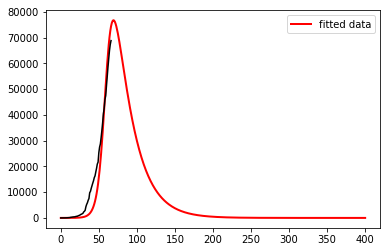

In [2400]:
plt.plot(time, data_fitted[:, 1], '-', linewidth=2, color='red', label='fitted data')
#plt.plot(time, data_fitted[:, 2], '-', linewidth=2, color='green', label='recover')
#plt.plot(time, data_fitted[:, 0], '-', linewidth=2, color='blue', label='Susceptible')
plt.legend()
plt.plot(cases,color='black',label='Data')
report_fit(result)

plt.show()

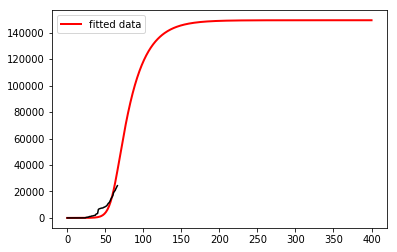

In [2401]:
plt.plot(time, data_fitted[:, 2], '-', linewidth=2, color='red', label='fitted data')
#plt.plot(time, data_fitted[:, 2], '-', linewidth=2, color='green', label='recover')
#plt.plot(time, data_fitted[:, 0], '-', linewidth=2, color='blue', label='Susceptible')
plt.legend()
plt.plot(recuperados,color='black',label='Data')
plt.show()

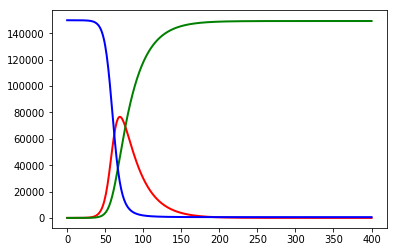

In [2402]:
plt.plot(time, data_fitted[:, 1], '-', linewidth=2, color='red', label='fitted data')
plt.plot(time, data_fitted[:, 2], '-', linewidth=2, color='green', label='recover')
plt.plot(time, data_fitted[:, 0], '-', linewidth=2, color='blue', label='Susceptible')

# Simulacion de condiciones iniciales

In [2403]:
# The SIR model differential equations.4
def deriv(y, t, paras):
    
    try:
        beta = paras['beta'].value
        gamma = paras['gamma'].value
        e = paras['e'].value
        N = paras['N'].value
        
    except KeyError:
        beta, gamma,N = paras
        
    
    S, I, R = y
    #dSdt = -beta * S * I /(N*e)
    #dIdt = beta * S * I /(N*e)  - gamma * I
    #Mejor
    dSdt = -beta * S * I /(N)
    dIdt = beta * S * I /(N)  - gamma * I
    #Cambio
    #dSdt = -beta * S * I 
    #dIdt = beta * S * I   - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [2404]:
#x0 es y0

def g(t, x0, paras):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """ 
    x = odeint(deriv, x0, t, args=(paras,) )
    return x


In [2405]:
def residual(paras, t, data):

    """
    compute the residual between actual data and fitted data
    """

    x0 = paras['S0'].value, paras['I0'].value, paras['R0'].value # Initial Conditions
    model = g(t, x0, paras)

    # you only have data for one of your variables
    x2_model = model.T[1]
    x3_model = model.T[2]
    # 50% , 50%
    return np.concatenate(((x2_model - cases),(x3_model-recuperados)))

In [2406]:
def simulate(N):
    #N = 31000000
    # Initial number of infected and recovered individuals, I0 and R0.
    I0, R0 = 1, 0
    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - I0 - R0
    # Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
    beta, gamma,e = 0.01, 0.01,0.000001
    # A grid of time points (in days)
    t = np.linspace(0, len(cases)-1, len(cases))
    # set parameters including bounds; you can also fix parameters (use vary=False)
    params = Parameters()
    params.add('S0', value=S0, vary=False)
    params.add('I0', value=I0, vary=False)
    params.add('R0', value=R0, vary=False)
    params.add('beta', value=beta, min=0.0001, max=7.)
    params.add('gamma', value=gamma, min=0.002, max=3.)
    params.add('e', value=e , min=0.000001, max=3.)
    #params.add('gamma', value=gamma,min=0.00020,max=0.00040,vary=True)
    #params.add('gamma', value=gamma,vary=False)
    #params.add('N', value=N, vary = True, min=60000,max= 300000)
    params.add('N', value=N, vary = False)
    y0 = [S0, I0, R0]
    result = minimize(residual, params, args=(t, cases), method='leastsq',nan_policy='omit')  # leastsq nelder
    return result

In [2407]:
iteracion=[]
error_cuadratico=[]
for N in range(120000,300000,5000):
    result = simulate(N)
    error_cuadratico.append(sum(result.residual)**2)
    iteracion.append(N)

In [2408]:
tabla=pd.DataFrame()
tabla['iteracion']=iteracion
tabla['error_cuadratico']=error_cuadratico

In [2409]:
tabla[tabla['error_cuadratico']==tabla['error_cuadratico'].min()]

,iteracion,error_cuadratico
0,120000,3.532423e+10


In [2410]:
iteracion_optima = tabla[tabla['error_cuadratico']==tabla['error_cuadratico'].min()]['iteracion']

In [2411]:
iteracion_optima= iteracion_optima.values[0]

In [2412]:
result =  simulate(iteracion_optima)

In [2413]:
result.params

name,value,initial value,min,max,vary
S0,119999.000,119999,-inf,inf,False
I0,1.00000000,1,-inf,inf,False
R0,0.00000000,0,-inf,inf,False
beta,0.23939283,0.01,1.0000e-04,7.00000000,True
gamma,0.03664381,0.01,0.00200000,3.00000000,True
e,1.0000e-06,1e-06,1.0000e-06,3.00000000,True
N,120000.000,120000,-inf,inf,False


In [2414]:
time =np.linspace(0., 400, 401)

In [2415]:
y0 =[iteracion_optima,1,0]
y0 # Es importante volver a actualizar esta lista  , se usa en el ODE 

[120000, 1, 0]

In [2416]:
data_fitted = g(time, y0, result.params)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 139
    # data points      = 134
    # variables        = 3
    chi-square         = 1.6406e+09
    reduced chi-square = 12523940.7
    Akaike info crit   = 2192.94836
    Bayesian info crit = 2201.64188
##  Warning: uncertainties could not be estimated:
    e:      at initial value
    e:      at boundary
[[Variables]]
    S0:     119999 (fixed)
    I0:     1 (fixed)
    R0:     0 (fixed)
    beta:   0.23939283 (init = 0.01)
    gamma:  0.03664381 (init = 0.01)
    e:      1.0000e-06 (init = 1e-06)
    N:      120000 (fixed)


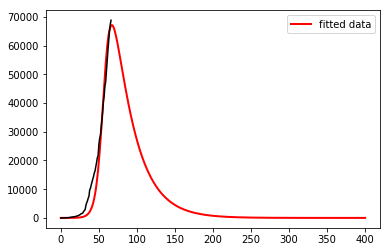

In [2417]:
plt.plot(time, data_fitted[:, 1], '-', linewidth=2, color='red', label='fitted data')
#plt.plot(time, data_fitted[:, 2], '-', linewidth=2, color='green', label='recover')
#plt.plot(time, data_fitted[:, 0], '-', linewidth=2, color='blue', label='Susceptible')
plt.legend()
plt.plot(cases,color='black',label='Data')
report_fit(result)

plt.show()

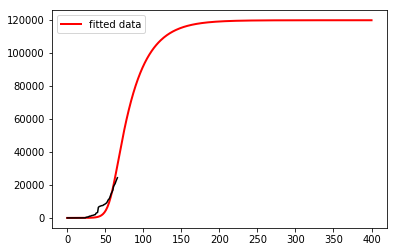

In [2418]:
plt.plot(time, data_fitted[:, 2], '-', linewidth=2, color='red', label='fitted data')
#plt.plot(time, data_fitted[:, 2], '-', linewidth=2, color='green', label='recover')
#plt.plot(time, data_fitted[:, 0], '-', linewidth=2, color='blue', label='Susceptible')
plt.legend()
plt.plot(recuperados,color='black',label='Data')
plt.show()

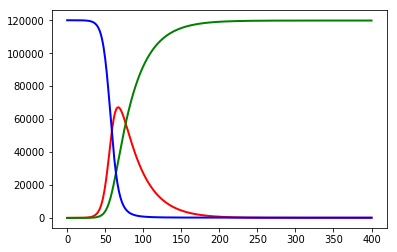

In [2419]:
plt.plot(time, data_fitted[:, 1], '-', linewidth=2, color='red', label='fitted data')
plt.plot(time, data_fitted[:, 2], '-', linewidth=2, color='green', label='recover')
plt.plot(time, data_fitted[:, 0], '-', linewidth=2, color='blue', label='Susceptible')

In [2429]:
visualizar=pd.DataFrame()
visualizar['infectados']=data_fitted[:, 1]

In [2446]:
print('Faltan: ',150-len(t),' dias') #En 150 dias aprox se termina la pandemia

Faltan:  83  dias


In [2443]:
83/30

2.7666666666666666